# 필요한 라이브러리 및 모듈

In [1]:
import pandas as pd
from konlpy.tag import Okt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec
from gensim.models import doc2vec
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import ast
import numpy as np
import math

def preprocessing(x, stop_words):
    okt = Okt()
    try:
        sentence_tokens = okt.nouns(x)
        result = ''
        #result = []
        for token in sentence_tokens: 
            if token not in stop_words:
                result += ' ' + token 
                #result.append(token)
        return result
    except:
        return '없음'
    
def rm_whitespace(x):
    result = []
    for i in x:
        if i != '':
            result.append(i)
        else:
            pass
    return result
    
# evaluation metrices: Precision, Recall, NDCG@K
def compute_metrics(pred_u, target_u, top_k):
    pred_k = pred_u[:top_k]
    num_target_items = len(target_u)

    hits_k = [(i + 1, item) for i, item in enumerate(pred_k) if item in target_u]
    # print("실제로 맞춘 items (position, idx):", hits_k)
    num_hits = len(hits_k)

    idcg_k = 0.0
    for i in range(1, min(num_target_items, top_k) + 1):
        idcg_k += 1 / math.log(i + 1, 2)

    dcg_k = 0.0
    for idx, item in hits_k:
        dcg_k += 1 / math.log(idx + 1, 2)
    
    prec_k = num_hits / top_k
    recall_k = num_hits / min(num_target_items, top_k)
    ndcg_k = dcg_k / idcg_k

    return prec_k, recall_k, ndcg_k

# 조건 설정하는 법
    
    1. 몇 편 이상의 유저로 사용할지
        - 데이터 전처리 파트에 #### code ####와 같이 존재하는 부분으로 이동
        - 아래 코드에 존재하는 숫자가 몇 편 이상으로 할지 선정
            df_user_watch.loc[df_user_watch['cnt_watch']>=10].index
    2. train-test 분리하는 법
        - 데이터 전처리 파트에 마찬가지로 #### code ####와 같이 존재하는 부분으로 이동
        - 랜덤 버전을 할 경우 #랜덤버전 아래의 코드 한줄만 앞의 코드에 #이 없도록 실행

          train, test = train_test_split(df, test_size=0.2, stratify=df['userr'],random_state = 1234)
          #flag_range = int(df.shape[0]*80)
          #df= df.sort_values(by=['year','month','day','hour','min','sec'],ascending=True)
          #train = df[:flag_range]
          #test = df[flag_range:]

        - 기간 선택 버전을 할 경우, #시간 선택 버전 아래의 코드들만 #을 없애고 실행
          
          #train, test = train_test_split(df, test_size=0.2, stratify=df['userr'],random_state = 1234)
          flag_range = int(df.shape[0]*80)
          df= df.sort_values(by=['year','month','day','hour','min','sec'],ascending=True)
          train = df[:flag_range]
          test = df[flag_range:]   
     3. 이전에 시청한 영화를 평가에 포함할지
         - 유저 평가하기 파트에 마찬가지로 #### code ####와 같이 존재하는 부분으로 이동
         - 포함 시킬 경우, 아래와 같이 진행(진행할 코드에만 #을 제거)

            #테스트할때 이전에 시청한 콘텐츠는 제외하고 평가하는것과 포함하여 평가하는것
            # 특정 user가 본 영화들 제외
            #train_items_by_user = train.loc[train.userr==user_id]
            #unique_items = unique_items[~unique_items['iitem1'].isin(train_items_by_user['iitem1'])]
            unique_items = unique_items
            
        - 미포함 시킬 경우, 아래와 같이 진행
        
            #테스트할때 이전에 시청한 콘텐츠는 제외하고 평가하는것과 포함하여 평가하는것
            # 특정 user가 본 영화들 제외
            train_items_by_user = train.loc[train.userr==user_id]
            unique_items = unique_items[~unique_items['iitem1'].isin(train_items_by_user['iitem1'])]
            #unique_items = unique_items
    4. 변수 추가
        - 해당 경우는 워낙 경우의 수가 많아서 완전하게 해드릴 수는 없을 것 같구요. 기본적으로 추가하는 방법을 알려드리지만,
        오류가 나면 저한테 알려주시거나 한번 해결해보세요. 
        - 설명은 적어놓았는데 다음과 같습니다.

           0. 아래의 과정들을 진행했는데도 오류가 난다면, 데이터 안에 값 자체를 전처리해주어야 합니다.
                null,nan과 같은 결측값을 대체해주거나, 문자나 리스트와 같은 값들로 변경해주어야 합니다.
                df['genre'] = df['genre'].apply(lambda x: x.split("|"))
                df['genre'] = df['genre'].apply(lambda x: rm_whitespace(x))
                df['actors'] = df['actors'].fillna('없음')
           1. 데이터 전처리 ~ 유저 평가하기 이전 까지의 코드 중에 수정할 곳들이 존재합니다
           2. "# n단계 조건 : 새로운 변수 추가" 라는 주석이 존재하는 곳에 갑니다
           3. "# new_feature = 'genre_people_country'#<<여기에 해당 형식으로 추가" 아래의 내용을 참고해서 코드를 완료합니다
           4. 컬럼 안에 값의 종류에 따라 각기 다른 코드를 수정해야 해서 이 부분만 주의해서 반영해주세요
           
              # 경우의 수 1 - 컬럼의 값이 장르처럼 리스트일 경우, ['코미디','드라마']
              # columns = x['column']#<< 여기에 추가할 컬럼명 추가
              #for column in columns:
              #    result += ' ' + column        

              # 경우의 수 2 - 컬럼의 값이 국가처럼 문자일 경우, '한국'
              # result += ' ' + x['summary']#<< 여기에 추가할 컬럼명 추가

# 데이터 불러오기

In [2]:
# 데이터가 커서 길이를 설정해놓았습니다. nrows=10000 자체를 없애거나 숫자를 변경해서 데이터 크기를 조정해보세요.
df = pd.read_csv('test2.csv', nrows = 100000)
df_stopwords = pd.read_csv('data/한국어불용어100.txt',sep='\t', header=None,names=['words','b','c'])
lst_words = df_stopwords['words'].values

In [3]:
df.columns = ['userr','iitem1','ttime',
             'title','subtitle','main_genre','genre',
             'keyword','actors','country','price','summary']

# 데이터 전처리

In [4]:
# 1단계 조건 : 새로운 변수 추가
def preprocessing_(x):
    
    
    result = ''
    
    genres = x['genre']
    for genre in genres:
        result += ' ' + genre 

    result += ' ' + x['country']
    result += ' ' + x['summary']
    
    # 경우의 수 1 - 컬럼의 값이 장르처럼 리스트일 경우, ['코미디','드라마']
    # columns = x['column']#<< 여기에 추가할 컬럼명 추가
    #for column in columns:
    #    result += ' ' + column        

    # 경우의 수 2 - 컬럼의 값이 국가처럼 문자일 경우, '한국'
    # result += ' ' + x['column']#<< 여기에 추가할 컬럼명 추가
    return result

In [5]:
df['summary'] = df['summary'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
df['summary'] = df['summary'].apply(lambda x: preprocessing(x, lst_words))

# 1회 이상 시청 고객
df_user_watch=pd.DataFrame(df['userr'].value_counts())
df_user_watch.columns=['cnt_watch']
#######################################################################################################
# 학습데이터를 몇 편이상을 시청한 user로쓸지
lst_user_real = df_user_watch.loc[df_user_watch['cnt_watch']>=10].index
#######################################################################################################

df = df.loc[df['userr'].isin(lst_user_real)]

# 유저 아이디 인코딩

le = LabelEncoder()
df['userr'] = le.fit_transform(df['userr']).astype(int)

df['genre'] = df['genre'].apply(lambda x: x.split("|"))
df['genre'] = df['genre'].apply(lambda x: rm_whitespace(x))
df['actors'] = df['actors'].fillna('없음')
df['country'] = df['country'].fillna('없음')
df['genre'] = df['genre'].fillna('없음')
df['year']=df['ttime'].apply(lambda x: str(x)[:4])
df['month']=df['ttime'].apply(lambda x: str(x)[4:6])
df['day']=df['ttime'].apply(lambda x: str(x)[6:8])
df['hour']=df['ttime'].apply(lambda x: str(x)[8:10])
df['min']=df['ttime'].apply(lambda x: str(x)[10:12])
df['sec']=df['ttime'].apply(lambda x: str(x)[12:])

df['comebine_col'] = df.apply(lambda x: preprocessing_(x), axis=1)

In [6]:
# 전체 데이터셋의 user, item 수 확인
user_list = list(df['userr'].unique())
item_list = list(df['iitem1'].unique())
num_users = len(user_list)
num_items = len(item_list)
print(f"# of users: {num_users}, # of items: {num_items}")

# train, test set 나누기
train, test = train_test_split(df, test_size=0.2, stratify=df['userr'],random_state = 1234)
#######################################################################################################
#train-test는 랜덤버전과 
#랜덤버전
train, test = train_test_split(df, test_size=0.2, stratify=df['userr'],random_state = 1234)
#시간 선택 버전
#flag_range = int(df.shape[0]*80)
#df= df.sort_values(by=['year','month','day','hour','min','sec'],ascending=True)
#train = df[:flag_range]
#test = df[flag_range:]
#######################################################################################################

# 전체 데이터셋을 돌면서 모든 종류의 영화 장르, 국가, 배우 확인


# genre, country, people
selected_features = ["genre", "country", "actors", "summary"]
all_genre_list = []
all_country_list = []
all_people_list = []
all_plot_list = []

for index, row in train.iterrows():
    genres = row["genre"]
    coutries = row["country"]
    people = row["actors"]
    plots = row["summary"]
    #genres = ast.literal_eval(genres)
    #coutries = ast.literal_eval(coutries)
    #people = ast.literal_eval(people)
    for genre in genres:
        if genre not in all_genre_list:
            all_genre_list.append(genre)
    for country in coutries:
        if country not in all_country_list:
            all_country_list.append(country)
    #print(people)
    for person in people:
        if person not in all_people_list:
            all_people_list.append(person)
    for plot in plots:
        if plot not in all_plot_list:
            all_plot_list.append(plot)
num_genres = len(all_genre_list)
num_countries = len(all_country_list)
num_people = len(all_people_list)
num_plot = len(all_plot_list)


tfidf = TfidfVectorizer(min_df = 10, sublinear_tf = True, max_features=50)
tfidf_matrix = tfidf.fit_transform(train['comebine_col'].astype(str))
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
title_to_index = dict(zip(train['title'], train.index))

tfidf_vector = []
for val in np.array(tfidf_matrix.todense()):
    tfidf_vector.append(val)
train['tfidf_vector'] = tfidf_vector   

# of users: 1727, # of items: 719


In [7]:
grouped_sum = train.groupby('userr')['tfidf_vector'].apply(lambda x: [sum(y) for y in zip(*x)])
num_features = len(train['tfidf_vector'].iloc[0])

user_bin = {}
for user_idx in user_list:
    total_bin = np.zeros(num_features)
    num_dim = int(len(grouped_sum[user_idx])/num_features)

    for i in range(num_dim):
        one_movie = np.array(grouped_sum[user_idx][i*num_features:(i+1)*num_features])
        zipped_lists = zip(total_bin, one_movie)
        total_bin = [x + y for (x, y) in zipped_lists]

    total_bin = np.array(total_bin)
    user_bin[user_idx] = (total_bin, num_dim)

## 특정 유저에 대해서 평가하기

In [8]:
# 특정 user의 one-hot vector 확인해보기
user_id = 10
total_bin = user_bin[user_id][0]
num_movies = user_bin[user_id][1]
print(f"# of movies watched by user {user_id}: {num_movies}")
#print("one-hot vector:", total_bin)
#print("normalized one-hot vector:", total_bin / num_movies)


# combined one-hot vector를 가지고 다른 item들과의 cosine similarity 계산
norm_bin = total_bin / num_movies

# unique item 추리기
unique_items = train[['iitem1', 'title', 'genre', 'country', 'tfidf_vector']].drop_duplicates(['iitem1'])

#############################################################################
#테스트할때 이전에 시청한 콘텐츠는 제외하고 평가하는것과 포함하여 평가하는것
# 특정 user가 본 영화들 제외
train_items_by_user = train.loc[train.userr==user_id]
unique_items = unique_items[~unique_items['iitem1'].isin(train_items_by_user['iitem1'])]
#unique_items = unique_items
#############################################################################
unique_items['similarity'] = unique_items['tfidf_vector'].apply(lambda x: np.array(x).dot(norm_bin) / (np.array(x).sum() + 1e-10))
unique_items.head()

# cosine similarity를 토대로 top-k item 구하기
sorted_items = unique_items.sort_values(by=['similarity'], axis=0, ascending=False)
sorted_items.head()

top_k = 10
top_k_items = list(sorted_items['iitem1'][:top_k])
top_item_df = sorted_items[['iitem1', 'title', 'genre']].drop_duplicates(['iitem1'])
# 예측한 top-k items
top_item_df[top_item_df['iitem1'].isin(top_k_items[:top_k])]

# user가 실제로 본 영화들
user_id = 10
test_items_by_user = test.loc[test.userr==user_id]
test_items_by_user[['userr', 'iitem1', 'title', 'genre']]

# user 한 명에 대한 평가
top_k = 200
pred_u = list(sorted_items['iitem1'])
target_u = list(test_items_by_user['iitem1'])

prec, recall, ndcg = compute_metrics(pred_u, target_u, top_k)
print(f"Precison@{top_k}: {prec:.4f}")
print(f"Recall@{top_k}: {recall:.4f}")
print(f"NDCG@{top_k}: {ndcg:.4f}")

# of movies watched by user 10: 1
Precison@200: 0.0000
Recall@200: 0.0000
NDCG@200: 0.0000


## 전체 유저에 대해서 평가하기

In [9]:
# 전체 user에 대한 평가
top_k = 200
prec_list = []
recall_list = []
ndcg_list = []

# unique item 추리기
ori_unique_items = train[['iitem1', 'title', 'genre', 'country', 'tfidf_vector']].drop_duplicates(['iitem1'])

for user_id in user_list:
    total_bin = user_bin[user_id][0]
    num_movies = user_bin[user_id][1]

    # combined one-hot vector를 가지고 다른 item들과의 cosine similarity 계산
    norm_bin = total_bin / num_movies
    #############################################################################
    #테스트할때 이전에 시청한 콘텐츠는 제외하고 평가하는것과 포함하여 평가하는것
    # 특정 user가 본 영화들 제외
    train_items_by_user = train.loc[train.userr==user_id]
    unique_items = ori_unique_items[~ori_unique_items['iitem1'].isin(train_items_by_user['iitem1'])]
    #unique_items = unique_items
    #############################################################################
    unique_items['similarity'] = unique_items['tfidf_vector'].apply(lambda x: np.array(x).dot(norm_bin) / (np.array(x).sum() + 1e-10))

    # cosine similarity를 토대로 top-k item 구하기
    sorted_items = unique_items.sort_values(by=['similarity'], axis=0, ascending=False)

    test_items_by_user = test.loc[test.userr==user_id]
    pred_u = list(sorted_items['iitem1'])
    target_u = list(test_items_by_user['iitem1'])

    prec, recall, ndcg = compute_metrics(pred_u, target_u, top_k)
    prec_list.append(prec)
    recall_list.append(recall)
    ndcg_list.append(ndcg)

print(f"Precision@{top_k}: {np.mean(prec_list):.4f}")
print(f"Recall@{top_k}: {np.mean(recall_list):.4f}")
print(f"NDCG@{top_k}: {np.mean(ndcg_list):.4f}")

C:\Users\admin\anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Precision@200: 0.0011
Recall@200: 0.0805
NDCG@200: 0.0303


# tf idf 시각화 

In [10]:
import pandas as pd
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
from future.utils import iteritems
from collections import Counter
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [11]:
tfidf.idf_

array([1.92202764, 3.26196177, 3.9303388 , 4.0032282 , 3.18319695,
       3.27154481, 3.45030638, 4.39910268, 4.6838522 , 3.04840126,
       2.29598978, 1.7440475 , 3.27762603, 4.0874804 , 3.19435925,
       3.24862824, 4.25284969, 4.02193432, 3.95971154, 4.03792248,
       4.17244109, 3.16187831, 3.42379525, 4.19194526, 3.65863484,
       3.25562372, 2.3328256 , 3.11994476, 4.17507846, 3.45201359,
       3.30012335, 3.03283123, 3.3186424 , 3.18810614, 4.20455804,
       3.05441072, 2.47417899, 3.35985388, 4.00471188, 3.24098931,
       4.64931639, 3.19899195, 3.16604165, 1.85158668, 4.22101179,
       3.2241822 , 4.60775916, 4.42363011, 1.36788421, 4.16544194])

In [12]:
# 특정 문서의 weight 값 
first_vector_tfidfvectorizer=tfidf_matrix[0] 
 
# place tf-idf values in a pandas data frame 
df_weight = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), 
                  index=tfidf.get_feature_names(), 
                  columns=["tfidf"]) 
df_weight.sort_values(by=["tfidf"],ascending=False)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,tfidf
풍선,0.783576
에디,0.460972
선물,0.338317
tv만화,0.155747
친구,0.150039
한국,0.110843
엄마,0.000000
뽀롱뽀롱,0.000000
성장,0.000000
순이,0.000000


## TF-IDF를 사용하여 단어의 중요도를 산출하였고, 선택된 100개의 단어를 t-SNE로 시각화

In [13]:
tfidf_dict = tfidf.get_feature_names()
data_array = tfidf_matrix.toarray()
data = pd.DataFrame(data_array, columns=tfidf_dict)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [14]:
tsne = TSNE(n_components=2, n_iter=1000, verbose=1)

In [15]:
Z = tsne.fit_transform(data_array.T)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
C:\Users\admin\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 49 nearest neighbors...
[t-SNE] Indexed 50 samples in 0.001s...
[t-SNE] Computed neighbors for 50 samples in 0.028s...
[t-SNE] Computed conditional probabilities for sample 50 / 50
[t-SNE] Mean sigma: 15.334380
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.864079
[t-SNE] KL divergence after 1000 iterations: 0.374670


tv만화
겨울
계획
공룡
공연
공연장
교실
꺼병이
꽃잎
날씨
노래
노래율동
노랫소리
놀이
도움
돼지
루피
마샤
망원경
모두
모습
바람
발달
배달
보고
불어
뽀로로
뽀롱뽀롱
선물
성장
순이
아기
아이
아주
아홉
엄마
없음
에디
위해
율동
정말
준비
축구
친구
크롱
통통이
풍선
핑크퐁
한국
호기


C:\Users\admin\anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\admin\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


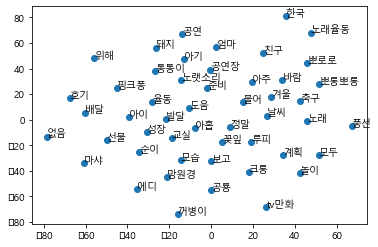

In [16]:
from matplotlib import font_manager
font_fname = 'C:/Windows/Fonts/malgunsl.ttf'
font_family = font_manager.FontProperties(fname=font_fname).get_name()
plt.rcParams["font.family"] = font_family

plt.scatter(Z[:,0], Z[:,1])
for i in range(len(tfidf_dict)):
    print(tfidf_dict[i])
    plt.annotate(tfidf_dict[i], xy=(Z[i,0], Z[i,1]))

plt.draw()

## 클러스터링 시각화

In [17]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

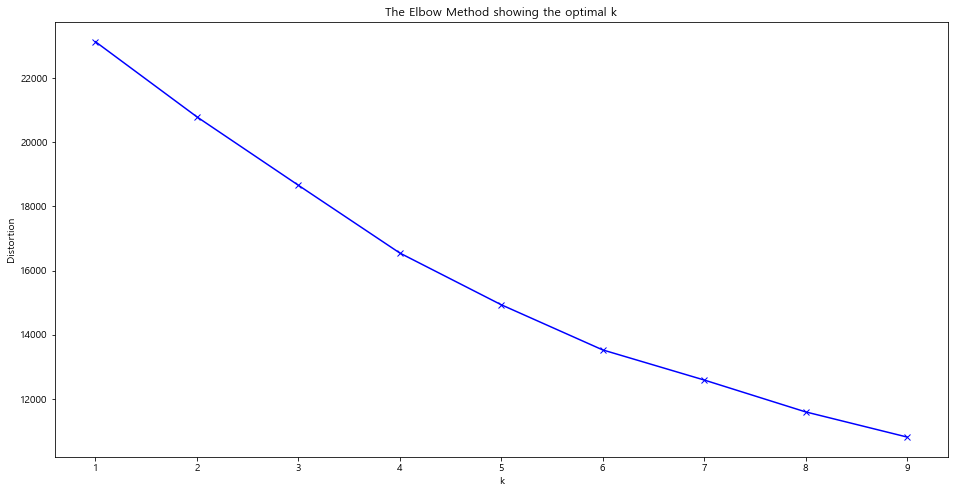

In [18]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(tfidf_matrix)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [19]:
# initialize kmeans with 3 centroids
kmeans = KMeans(n_clusters=3, random_state=42)
# fit the model
kmeans.fit(tfidf_matrix)
# store cluster labels in a variable
clusters = kmeans.labels_

In [20]:
# initialize PCA with 2 components
pca = PCA(n_components=2, random_state=42)
# pass X to the pca
pca_vecs = pca.fit_transform(tfidf_matrix.toarray())
# save the two dimensions in x0 and x1
x0 = pca_vecs[:, 0]
x1 = pca_vecs[:, 1]

# assign clusters and PCA vectors to columns in the original dataframe
df_cluster_tfidf = pd.DataFrame()
df_cluster_tfidf['cluster'] = clusters
df_cluster_tfidf['x0'] = x0
df_cluster_tfidf['x1'] = x1

C:\Users\admin\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


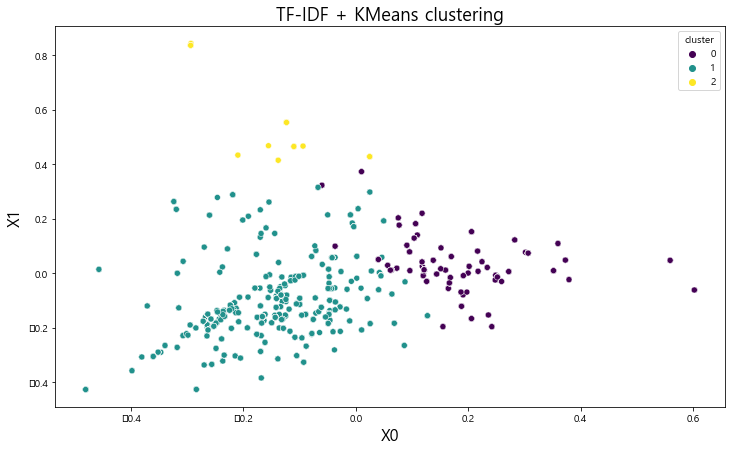

In [21]:
# set image size
plt.figure(figsize=(12, 7))
# set a title
plt.title("TF-IDF + KMeans clustering", fontdict={"fontsize": 18})
# set axes names
plt.xlabel("X0", fontdict={"fontsize": 16})
plt.ylabel("X1", fontdict={"fontsize": 16})
# create scatter plot with seaborn, where hue is the class used to group the data
sns.scatterplot(data=df_cluster_tfidf, x='x0', y='x1', hue='cluster', palette="viridis")
plt.show()